In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
# Set device and set to CUDA if GPU is available
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"
device

'cuda:0'

In [3]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 4090'

## Dataset classes

In [4]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms


class SiameseDataset(Dataset):

    """
    Clase para crear un dataset de siamesas que genera pares de imágenes
    etiquetadas como similares o diferentes.

    Esta clase permite generar combinaciones positivas y negativas de imágenes,
    garantizando que no se repitan pares (independientemente del orden) y
    limitando el número de veces que una imagen puede ser seleccionada.

    Args:
        image_folder (str): Ruta a la carpeta que contiene las imágenes organizadas por clase.
        transform (callable, optional): Transformaciones a aplicar a las imágenes.
        max_positive_combinations (int, optional): Número máximo de combinaciones positivas permitidas por imagen.
        max_negative_combinations (int, optional): Número máximo de combinaciones negativas permitidas por imagen.

    Attributes:
        pairs (list): Lista de pares de imágenes generadas.
        generated_pairs (set): Conjunto para almacenar pares ya generados (sin importar el orden).
    """

    def __init__(self, image_folder, transform=None, max_positive_combinations=5, max_negative_combinations=5, seed=42):
        self.image_folder = image_folder
        self.transform = transform

        if seed is not None:
            random.seed(seed)
            torch.manual_seed(seed)
        
        if not self.transform:
            self.transform = transforms.Compose([
                transforms.ToTensor()        
            ])
        self.classes = os.listdir(image_folder)
        self.class_dict = {class_name: os.listdir(os.path.join(image_folder, class_name)) for class_name in self.classes}

        # Conjunto para almacenar combinaciones ya utilizadas (sin importar el orden)
        self.generated_pairs = set()

        # Generar todas las combinaciones posibles
        self.pairs = []
        self.generate_combinations(max_positive_combinations, max_negative_combinations)

    def _add_pair(self, img1, img2, label, class_name1, class_name2):
        """
        Añade un par al dataset si no ha sido generado previamente.
        """
        pair_key = frozenset([img1, img2])  # Usamos frozenset para evitar repetición sin importar el orden
        if pair_key not in self.generated_pairs:
            self.generated_pairs.add(pair_key)
            self.pairs.append((img1, img2, class_name1, class_name2, label))

    def generate_combinations(self, max_positive_combinations, max_negative_combinations):
        """
        Genera todas las combinaciones de pares de imágenes, respetando los límites
        de combinaciones positivas y negativas, evitando duplicados por imagen.
        """
        # Generar combinaciones positivas (máx. max_positive_combinations por imagen)
        for class_name, images in self.class_dict.items():
            num_images = len(images)
            for img1 in images:
                # Calcular la cantidad máxima posible de combinaciones positivas para esta imagen
                max_possible_combinations = min(max_positive_combinations, num_images - 1)
                positive_count = 0  # Contador para limitar combinaciones por imagen
                # Generar combinaciones positivas mientras haya posibilidades
                while positive_count < max_possible_combinations:
                    img2 = random.choice(images)
                    if img1 != img2:  # Evitar pares con la misma imagen
                        self._add_pair(img1, img2, 1, class_name, class_name)  # Etiqueta 1 = Positiva
                        positive_count += 1
        
        # Generar combinaciones negativas (máx. max_negative_combinations por imagen)
        for class_name1, images1 in self.class_dict.items():
            for img1 in images1:
                negative_count = 0  # Contador para limitar combinaciones por imagen
                while negative_count < max_negative_combinations:
                    # Seleccionar una clase diferente para generar el par negativo
                    class_name2 = random.choice([c for c in self.classes if c != class_name1])
                    img2 = random.choice(self.class_dict[class_name2])
                    self._add_pair(img1, img2, 0, class_name1, class_name2)  # Etiqueta 0 = Negativa
                    negative_count += 1

        random.shuffle(self.pairs)  # Mezclar los pares para asegurar la aleatoriedad

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        # Obtener los pares pre-generados
        img1_name, img2_name, class_name1, class_name2, label = self.pairs[idx]
        
        img1_path = os.path.join(self.image_folder, class_name1, img1_name)
        img2_path = os.path.join(self.image_folder, class_name2, img2_name)

        img1 = Image.open(img1_path) 
        img2 = Image.open(img2_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor([label], dtype=torch.float32)

In [5]:
batch_size = 128

transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor()
    ])

train_dataset = SiameseDataset(
    "./cropped_selected_split_data/train",
    transform = transform,
    max_positive_combinations=7,
    max_negative_combinations=7
    )

validation_dataset = SiameseDataset(
    "./cropped_selected_split_data/val",
    transform = transform,
    max_positive_combinations=5,
    max_negative_combinations=5
    )

dataloader = {
    'train': DataLoader(train_dataset, shuffle=True, batch_size=batch_size),
    'val': DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
}

tensor([1.])


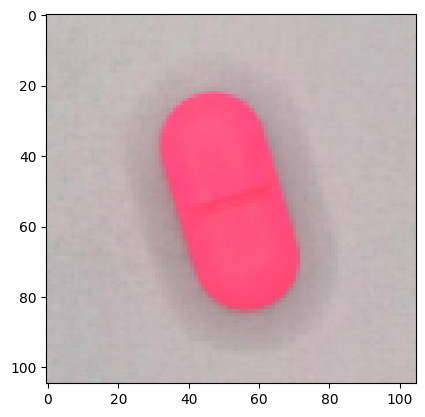

In [6]:
img1,img2,label = train_dataset[10]
img1
plt.imshow( img1.permute(1, 2, 0)  )
plt.imshow( img2.permute(1, 2, 0)  )
print(label)

## Model
Paper: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
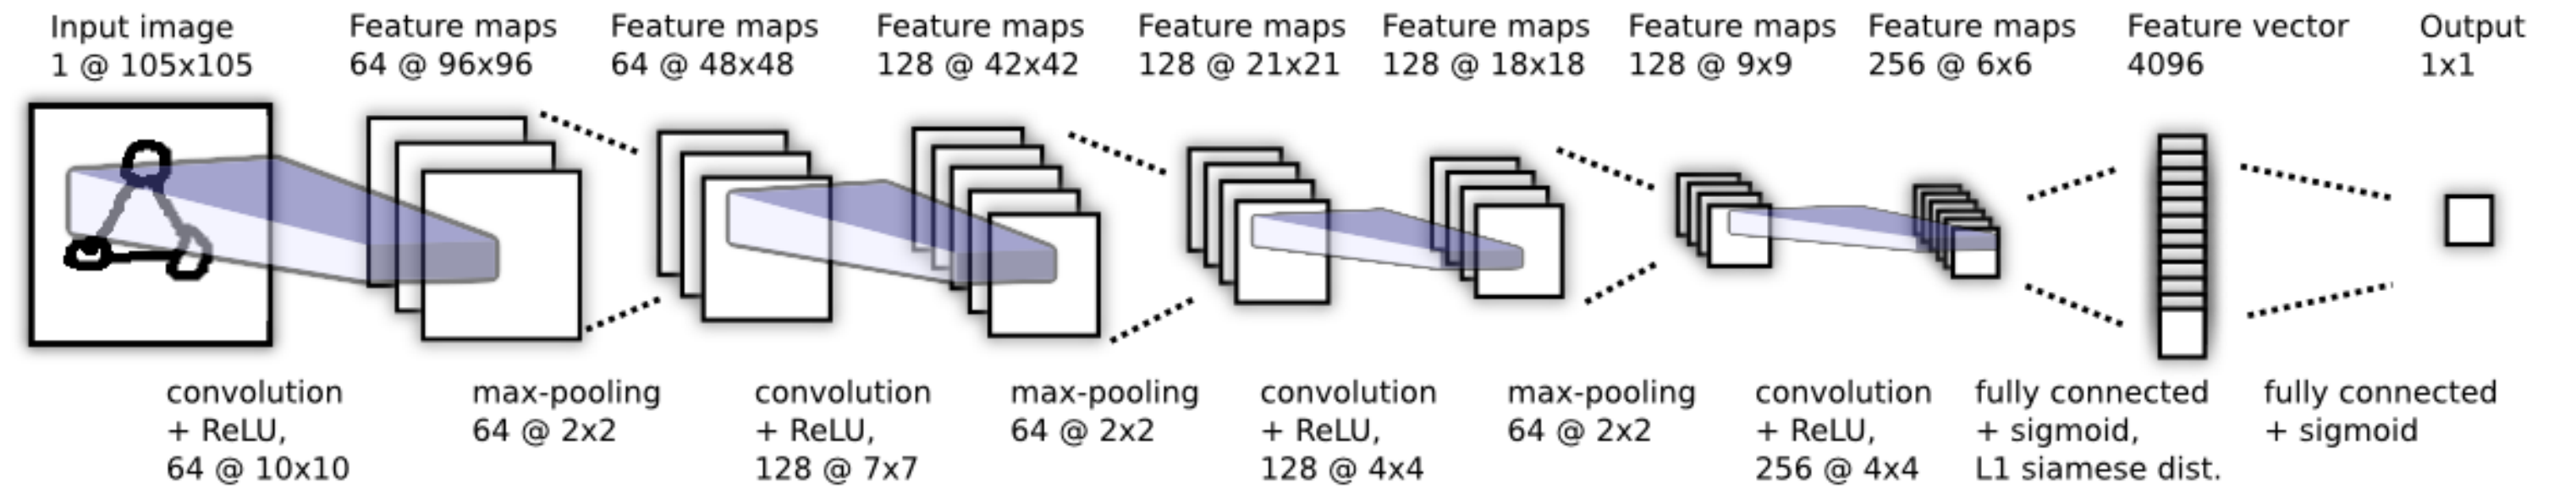

Based in the original paper, adapted to 105*105 images (credits to https://github.com/fangpin/siamese-pytorch). Adding a Batch Normalization to speed training up and avoid having to use parameters initialization techniques. It algo regularizes the network so no dropouts needed. Most internet discussions places the BN layer after activation, contrary to the original paper suggestion. 

In [7]:
class OneShot(nn.Module):
    def __init__(self):
        super(OneShot, self).__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(3, 64, 10),  # 64@96*96
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),  # 64@48*48
        nn.Conv2d(64, 128, 7),
        nn.ReLU(),    # 128@42*42
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),   # 128@21*21
        nn.Conv2d(128, 128, 4),
        nn.ReLU(), # 128@18*18
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2), # 128@9*9
        nn.Conv2d(128, 256, 4),
        nn.ReLU(),   # 256@6*6
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [8]:
class Siamese(nn.Module):

    def __init__(self, backbone, backbone_output_size = 9216):
        super(Siamese, self).__init__()
        self.backbone = backbone
        self.liner = nn.Sequential(nn.Linear(backbone_output_size, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.backbone(x)
        x = torch.flatten(x,1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        #  return self.sigmoid(out)
        return out

In [25]:
oneshot = OneShot()
model = Siamese(oneshot,9216)
summary(model)

Layer (type:depth-idx)                   Param #
Siamese                                  --
├─OneShot: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  19,264
│    │    └─ReLU: 3-2                    --
│    │    └─BatchNorm2d: 3-3             128
│    │    └─MaxPool2d: 3-4               --
│    │    └─Conv2d: 3-5                  401,536
│    │    └─ReLU: 3-6                    --
│    │    └─BatchNorm2d: 3-7             256
│    │    └─MaxPool2d: 3-8               --
│    │    └─Conv2d: 3-9                  262,272
│    │    └─ReLU: 3-10                   --
│    │    └─BatchNorm2d: 3-11            256
│    │    └─MaxPool2d: 3-12              --
│    │    └─Conv2d: 3-13                 524,544
│    │    └─ReLU: 3-14                   --
├─Sequential: 1-2                        --
│    └─Linear: 2-2                       37,752,832
│    └─Sigmoid: 2-3                      --
├─Linear: 1-3                            

In [20]:
test = OneShot()
img1, img2, label = validation_dataset[1]
res = test(img1.unsqueeze(0))
torch.flatten(res).size()

torch.Size([9216])

## Training

In [19]:
def fit(model, dataloader, device, optimizer, criterion, metric = None, epochs=15, show_bar = True, name = 'Siamese'):
    model.to(device)
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    best_val_acc = 0
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'], disable = not show_bar)
        for batch in bar:
            img1, img2, y = batch
            img1, img2, y = img1.to(device), img2.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(img1,img2)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            # Metrics
            if(metric is not None): acc = metric(y_hat, y)
            else: acc = (y == (F.sigmoid(y_hat) > 0.5).float()).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['val'],disable = not show_bar)
        val_loss, val_acc = [], []        
        model.eval()
        with torch.no_grad():
            for batch in bar:
                img1, img2, y = batch
                img1, img2, y = img1.to(device), img2.to(device), y.to(device)
                y_hat = model(img1,img2)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                if(metric is not None): acc = metric(y_hat, y)
                else: acc = (y == (F.sigmoid(y_hat) > 0.5).float()).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        
        if(show_bar):
            print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))
        if(epoch_v_acc[-1] > best_val_acc):
            best_val_acc = epoch_v_acc[-1]
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            },f'.//checkpoints//{name}.ckpt')
            print(f"Best model saved with Validation Accuracy: {best_val_acc:.4f}")

    return {
        "train_loss": epoch_t_loss,
        "validation_loss": epoch_v_loss,
        "train_accuracy": epoch_t_acc,
        "validation_accuracy": epoch_v_acc
    }

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay= 0.001)
criterion = torch.nn.BCEWithLogitsLoss()

results = fit(model, dataloader, device, optimizer, criterion, epochs = 5)

val_loss 0.31133 val_acc 0.88101: 100%|██████████| 82/82 [02:03<00:00,  1.51s/it]


Epoch 1/5 loss 0.18763 val_loss 0.31133 acc 0.94004 val_acc 0.88101
Best model saved with Validation Accuracy: 0.8810


val_loss 0.16695 val_acc 0.95941: 100%|██████████| 82/82 [02:05<00:00,  1.54s/it]


Epoch 2/5 loss 0.19565 val_loss 0.16695 acc 0.94201 val_acc 0.95941
Best model saved with Validation Accuracy: 0.9594


val_loss 0.15525 val_acc 0.96046: 100%|██████████| 82/82 [02:03<00:00,  1.51s/it]


Epoch 3/5 loss 0.16743 val_loss 0.15525 acc 0.95392 val_acc 0.96046
Best model saved with Validation Accuracy: 0.9605


val_loss 0.24515 val_acc 0.91870: 100%|██████████| 82/82 [02:04<00:00,  1.51s/it]


Epoch 4/5 loss 0.17064 val_loss 0.24515 acc 0.95437 val_acc 0.91870


val_loss 0.14428 val_acc 0.96500: 100%|██████████| 82/82 [02:03<00:00,  1.51s/it]


Epoch 5/5 loss 0.16310 val_loss 0.14428 acc 0.95646 val_acc 0.96500
Best model saved with Validation Accuracy: 0.9650


In [37]:
def show_graph(results):
        fig, ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].plot(results['train_loss'], label="Train loss")
        ax[0].plot(results['validation_loss'], label="Validation loss")
        ax[0].legend()
        ax[0].set_title("Loss by epoch")
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel("CE")

        ax[1].plot(results['train_accuracy'], label="Train accuracy")
        ax[1].plot(results['validation_accuracy'], label="Validation accuracy")
        ax[1].legend()
        ax[1].set_title("Scores")
        ax[1].set_xlabel("epoch")
        ax[1].set_ylabel("accuracy")
        plt.show()

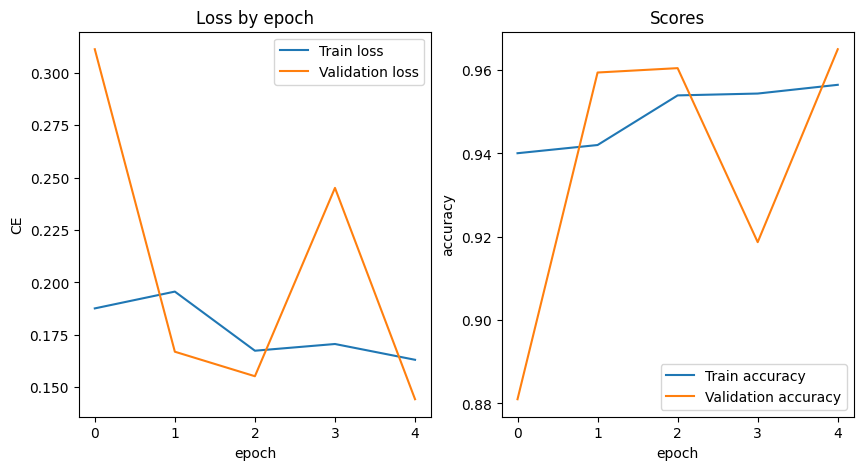

In [38]:
show_graph(results)

## Test

In [46]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix


def infer_single_sample(test_loader, model):
    # Poner el modelo en modo evaluación
    model.to(device)
    model.eval()

    # Seleccionar imagen random
    test_iter = iter(test_loader)
    images1, images2, labels = next(test_iter)  # Toma el primer batch del loader
    idx = random.randint(0, len(labels) - 1)

    img1, img2, label = images1[idx].unsqueeze(0), images2[idx].unsqueeze(0), labels[idx].unsqueeze(0)

    img1, img2, label = img1.to(device), img2.to(device), label.to(device)

    with torch.no_grad():
        output = model(img1, img2)
        prediction = (F.sigmoid(output) > 0.5).float()  # Binarizar la predicción

    # Mostrar las imágenes y los resultados
    img1_np = img1.squeeze().cpu().numpy().transpose(1, 2, 0)
    img2_np = img2.squeeze().cpu().numpy().transpose(1, 2, 0)

    plt.figure(figsize=(8,4))

    # Mostrar la primera imagen
    plt.subplot(1, 2, 1)
    plt.imshow(img1_np)
    plt.title("Image 1")

    # Mostrar la segunda imagen
    plt.subplot(1, 2, 2)
    plt.imshow(img2_np)
    plt.title("Image 2")

    plt.show()

    # Imprimir la etiqueta verdadera y la predicción
    print(f"True Label: {label.item()}")
    print(f"Predicted Label: {prediction.item()}")

# Función para realizar inferencia y calcular métricas
def evaluate_model(test_loader, model):
    model.to(device)
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Realizar inferencia
            output = model(img1, img2)
            predictions = (F.sigmoid(output) > 0.5).float()  # Binarizar las predicciones

            # Guardar etiquetas y predicciones
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calcular las métricas
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=1)
    recall = recall_score(all_labels, all_predictions, zero_division=1)

    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return accuracy, precision, recall, conf_matrix

In [42]:
test_dataset = SiameseDataset(
    "./cropped_selected_split_data/test",
    transform = transform,
    max_positive_combinations=3,
    max_negative_combinations=5
    )

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

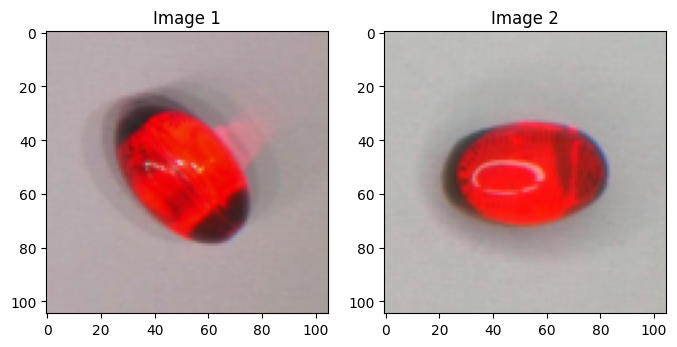

True Label: 1.0
Predicted Label: 1.0


In [44]:
infer_single_sample(test_dataloader, model)

### Load previously trained model

In [49]:
import seaborn as sns
bb = OneShot()
test_siamese = Siamese(bb,9216)
checkpoint = torch.load('.//checkpoints//Siamese.ckpt')
test_siamese.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Test with whole Test set

Test Accuracy: 0.9556
Test Precision: 0.8340
Test Recall: 0.9904


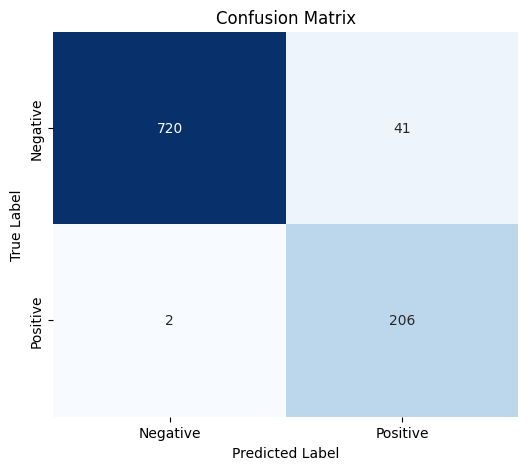

In [50]:
evaluate_model(test_dataloader, test_siamese)
test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(test_dataloader, test_siamese)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()